<a href="https://colab.research.google.com/github/lucasestrela/Dissertacao/blob/main/Rodando_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importando pacotes

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2) Importando os dados

Irei utilizar os custos do ciclo calculados e as informações dos países.

In [2]:
#############################################################################
######################## --- Lendo Base de Dados --- ########################
#############################################################################
custo = pd.read_csv('https://raw.githubusercontent.com/lucasestrela/Dissertacao/main/Dados/custos_data.csv',
                    header = 0,
                    index_col = 0
                    )


dados_paises = pd.read_csv('https://raw.githubusercontent.com/lucasestrela/Dissertacao/main/Dados/countries_data.csv',
                    header = 0,
                    index_col = 0
                    )

Faço o merge dos dataframes

In [3]:
# Fazendo o merge dos dois datasets
dataframe = pd.merge(custo, dados_paises, on='countrycode', left_index=True, right_index=True, how='left')
dataframe[['log_gdp_percapta', 'log_emp_pop', 'log_labsh']] = np.log(dataframe[['gdp_percapta', 'emp_pop', 'labsh']])

# Apagando as outras variáveis
del custo, dados_paises

In [4]:
dataframe.head()

,custo,countrycode,lvau_garriga,lvaw_garriga,stab_n,stab_s,gdp_percapta,emp_pop,avh,hc,rwtfpna,labsh,Freedom of elections,Electoral processes,Representative Institutions,Oversight institutions,Influence of organizations,Involvement of the military in politics,Political or Social expression via ITC,Population participation (national level),Population participation (local level),Freedom of association,Freedom of assembly,Equal treatment,Respect for the rights of minorities,Freedom of the Press,Genuine media pluralism,Freedom of access on the Internet,Freedom of access: cable/satellite,Freedom of access: foreign newspapers,Amendment of the rules governing the assumption of political office,Assumption of political office in accordance with the rules,Opposition to the most recent change of Head of State: political forces,Opposition to the most recent change of Head of State: population,Legitimacy of the political authorities: economic benefit,Legitimacy of the political authorities: social benefit,Legitimacy of the political authorities: national pride,Municipal authorities: elected or appointed,Other sub-national authorities: elected or appointed,Fiscal autonomy: municipal authorities,...,Efficiency of the system of industrial tribunals,Share of permanent contracts,Employment contract protection: individual dismissal,Employment contract protection: redundancies,Scale of strike movements: public sector,Scale of strike movements: private sector,Social dialogue effectiveness within companies,Social dialogue effectiveness at national level,Social dialogue effectiveness at branch level,Demands of workers' and employers' organisations taken into account,Workers' organizations and the general interest,Employers' organizations and the general interest,Ability to hire foreign executives in firms,Quality of public services: primary and secondary education (urban areas),Quality of public services: primary and secondary education (rural areas),Quality of public services: higher education/university,Quality of public services: basic healthcare,Quality of public services: public transport,Disparity in labour income,Discrimination on the labour market: community-based,Discrimination on the labour market: gender,Child labour in urban areas,Child labour in rural areas,Role of networks in recruitment and promotion of senior officials,Role of networks in recruitment and promotion in the administration,Role of networks in recruitment and promotion in the private sector,Irregularities in obtaining university degrees,Upward social mobility linked to merit,Unemployment rate for young university graduates,Reluctance to hire higher university graduates,Share of higher education graduates: informal sector,Redistribution mechanisms: poorer section of the population,Redistribution mechanisms: disadvantaged areas,Recognition of occupational health,Recognition of occupational safety,Proportion of unemployed young people in rural areas,Proportion of unemployed young people in urban areas,log_gdp_percapta,log_emp_pop,log_labsh
0,1.092658e+01,ABW,0.745530,0.807560,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.0,2.0,4.0,0.0,4.0,2.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0,4.0,3,4,4.0,0.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0,1.0,99.0,99.0,99.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN
1,inf,AGO,NaN,NaN,0.0,0.0,0.031580,0.562555,NaN,1.223680,1.11829,0.288399,2.0,1.0,2.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3,2,4.0,1.0,1.0,2.0,1.0,1.0,4.0,0.0,0.0,0.0,...,1.0,3.0,1.0,1.0,3.0,3.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1,3.0,4.0,2.0,1.0,1.0,2.0,2.0,1.0,0,-3.455220,-0.575267,-1.243412
2,1.805884e+68,AIA,0.670737,0.651866,0.0,0.0,0.256826,0.351060,NaN,2.450292,NaN,NaN,3.0,1.0,3.0,3.0,3.0,0.0,2.0,2.0,2.0,4.0,4.0,4.0,2.0,3.0,1.0,4.0,4,4,3.0,4.0,4.0,0.0,1.0,2.0,3.0,3.0,99.0,2.0,...,3.0,3.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,

(0.0, 200.0)

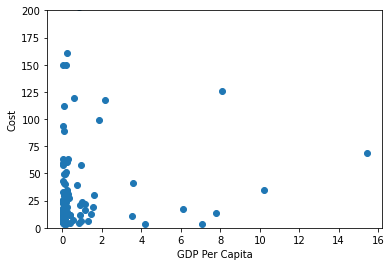

In [5]:
# Plotando o grafico
plt.scatter(x = dataframe['gdp_percapta'], y = dataframe['custo'])
plt.xlabel('GDP Per Capita')
plt.ylabel('Cost')
plt.ylim(0,200)

# 3) Rodando o Modelo

Para o python, é válido separar as variáveis entre X (covariadas) e y (variável independente) em dois dataframes separados.

In [6]:
df_filtered = dataframe[dataframe['custo'] < 100]

df_filtered.head()

,custo,countrycode,lvau_garriga,lvaw_garriga,stab_n,stab_s,gdp_percapta,emp_pop,avh,hc,rwtfpna,labsh,Freedom of elections,Electoral processes,Representative Institutions,Oversight institutions,Influence of organizations,Involvement of the military in politics,Political or Social expression via ITC,Population participation (national level),Population participation (local level),Freedom of association,Freedom of assembly,Equal treatment,Respect for the rights of minorities,Freedom of the Press,Genuine media pluralism,Freedom of access on the Internet,Freedom of access: cable/satellite,Freedom of access: foreign newspapers,Amendment of the rules governing the assumption of political office,Assumption of political office in accordance with the rules,Opposition to the most recent change of Head of State: political forces,Opposition to the most recent change of Head of State: population,Legitimacy of the political authorities: economic benefit,Legitimacy of the political authorities: social benefit,Legitimacy of the political authorities: national pride,Municipal authorities: elected or appointed,Other sub-national authorities: elected or appointed,Fiscal autonomy: municipal authorities,...,Efficiency of the system of industrial tribunals,Share of permanent contracts,Employment contract protection: individual dismissal,Employment contract protection: redundancies,Scale of strike movements: public sector,Scale of strike movements: private sector,Social dialogue effectiveness within companies,Social dialogue effectiveness at national level,Social dialogue effectiveness at branch level,Demands of workers' and employers' organisations taken into account,Workers' organizations and the general interest,Employers' organizations and the general interest,Ability to hire foreign executives in firms,Quality of public services: primary and secondary education (urban areas),Quality of public services: primary and secondary education (rural areas),Quality of public services: higher education/university,Quality of public services: basic healthcare,Quality of public services: public transport,Disparity in labour income,Discrimination on the labour market: community-based,Discrimination on the labour market: gender,Child labour in urban areas,Child labour in rural areas,Role of networks in recruitment and promotion of senior officials,Role of networks in recruitment and promotion in the administration,Role of networks in recruitment and promotion in the private sector,Irregularities in obtaining university degrees,Upward social mobility linked to merit,Unemployment rate for young university graduates,Reluctance to hire higher university graduates,Share of higher education graduates: informal sector,Redistribution mechanisms: poorer section of the population,Redistribution mechanisms: disadvantaged areas,Recognition of occupational health,Recognition of occupational safety,Proportion of unemployed young people in rural areas,Proportion of unemployed young people in urban areas,log_gdp_percapta,log_emp_pop,log_labsh
0,10.926580,ABW,0.745530,0.807560,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,3.0,2.0,4.0,0.0,4.0,2.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0,4.0,3,4,4.0,0.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0,1.0,99.0,99.0,99.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN
5,34.118703,ARG,0.815720,0.764900,0.000000,0.000000,0.244836,0.429386,NaN,3.079684,0.768842,0.681861,3.0,1.0,4.0,3.0,1.0,2.0,3.0,0.0,0.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3,3,1.0,2.0,4.0,2.0,1.0,1.0,2.0,3.0,0.0,1.0,...,3.0,3.0,2.0,2.0,4.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,0.0,1,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2,-1.407165,-0.845400,-0.382929
8,4.949920,AUS,0.665522,0.700192,0.000000,0.354839,0.079310,0.461429,1855.895747,2.872986,0.864308,0.615763,4.0,3.0,4.0,4.0,1.0,0.0,3.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4,4,4.0,4.0,3.0,1.0,4.0,4.0,4.0,3.0,3.0,1.0,...

In [7]:
##############################################################################
######################## --- Separando covariadas --- ########################
##############################################################################

# X = dataframe[['lvaw_garriga', 'stab_n', 'stab_s', 'gdp_percapta', 'emp_pop', 'avh', 'hc', 'rwtfpna', 'labsh']]
X = df_filtered[['lvaw_garriga', 'stab_n', 'stab_s', 'log_gdp_percapta', 'log_emp_pop', 'log_labsh']]
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

y = df_filtered['custo']


# Rodando o modelo
model = sm.OLS(y, X, missing='drop').fit(cov_type='HC0')

# Printando os resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  custo   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.6289
Date:                Thu, 11 Mar 2021   Prob (F-statistic):              0.707
Time:                        14:55:56   Log-Likelihood:                -336.80
No. Observations:                  76   AIC:                             687.6
Df Residuals:                      69   BIC:                             703.9
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               32.7431     12.050  